In [365]:
import torch.nn as nn

In [366]:
import torch
import torchvision.models as models

# Load pretrained backbone (e.g., ResNet50)
backbone = models.resnet50(pretrained=True)

# Save the pretrained weights
torch.save(backbone.state_dict(), 'pretrained_backbone.pth')

/home/kuba/.virenv/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kuba/.virenv/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
backbone_features = torch.nn.Sequential(*(list(backbone.children())[:-3]))``

In [368]:
list(backbone.children())[-4:]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [369]:
import torch

def diou_loss(preds, targets):
    """
    Calculate DIoU loss between prediction and target boxes.
    
    Args...
        preds... Predicted bounding boxes in format (x, y, width, height)
        targets... Target bounding boxes in format (x, y, width, height)
        
    Returns...
        DIoU loss value
    """
    # Convert (x, y, width, height) to (x1, y1, x2, y2)
    pred_x1 = preds[..., 0] - preds[..., 2] / 2
    pred_y1 = preds[..., 1] - preds[..., 3] / 2
    pred_x2 = preds[..., 0] + preds[..., 2] / 2
    pred_y2 = preds[..., 1] + preds[..., 3] / 2
    
    target_x1 = targets[..., 0] - targets[..., 2] / 2
    target_y1 = targets[..., 1] - targets[..., 3] / 2
    target_x2 = targets[..., 0] + targets[..., 2] / 2
    target_y2 = targets[..., 1] + targets[..., 3] / 2
    
    # Calculate intersection area
    x1 = torch.max(pred_x1, target_x1)
    y1 = torch.max(pred_y1, target_y1)
    x2 = torch.min(pred_x2, target_x2)
    y2 = torch.min(pred_y2, target_y2)
    
    intersection = torch.clamp((x2 - x1), min=0) * torch.clamp((y2 - y1), min=0)
    
    # Calculate union area
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
    union = pred_area + target_area - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)
    
    # Calculate the smallest enclosing box
    c_x1 = torch.min(pred_x1, target_x1)
    c_y1 = torch.min(pred_y1, target_y1)
    c_x2 = torch.max(pred_x2, target_x2)
    c_y2 = torch.max(pred_y2, target_y2)
    
    # Calculate the diagonal distance of the smallest enclosing box
    c_diag = torch.pow(c_x2 - c_x1, 2) + torch.pow(c_y2 - c_y1, 2)
    
    # Calculate the Euclidean distance between centers
    center_dist = torch.pow(preds[..., 0] - targets[..., 0], 2) + torch.pow(preds[..., 1] - targets[..., 1], 2)
    
    # Calculate DIoU
    diou = iou - center_dist / (c_diag + 1e-7)
    
    # Return DIoU loss
    return (1 - diou).mean()

In [370]:


# class IoULoss(nn.Module):
#     def __init__(self):
#         super(IoULoss, self).__init__()

#     def forward(self, pred, target):
#         return bbox_iou(pred, target).mean()
    
class DIoULoss(nn.Module):
    def __init__(self):
        super(DIoULoss, self).__init__()

    def forward(self, pred, target):
        return diou_loss(pred, target)



In [371]:

import torch
import torch.nn as nn
import numpy as np
 
 
class SIoU(nn.Module):
    # SIoU Loss https://arxiv.org/pdf/2205.12740.pdf
   def __init__(self, x1y1x2y2=False, eps=1e-7):
     super(SIoU, self).__init__()
     self.x1y1x2y2 = x1y1x2y2
     self.eps = eps
 
 
         
   def forward(self, box1, box2):
 
 
       # Get the coordinates of bounding boxes
       if self.x1y1x2y2:  # x1, y1, x2, y2 = box1
           b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
           b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
       else:  # transform from xywh to xyxy
           b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
           b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
           b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
           b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2
 
 
       # Intersection area
       inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
               (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
 
 
       # Union Area
       w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + self.eps
       w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + self.eps
       union = w1 * h1 + w2 * h2 - inter + self.eps
 
       # IoU value of the bounding boxes
       iou = inter / union
       cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
       ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
       s_cw = (b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5
       s_ch = (b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5
       sigma = torch.pow(s_cw ** 2 + s_ch ** 2, 0.5) + self.eps
       sin_alpha_1 = torch.abs(s_cw) / sigma
       sin_alpha_2 = torch.abs(s_ch) / sigma
       threshold = pow(2, 0.5) / 2
       sin_alpha = torch.where(sin_alpha_1 > threshold, sin_alpha_2, sin_alpha_1)
        
       # Angle Cost
       angle_cost = 1 - 2 * torch.pow( torch.sin(torch.arcsin(sin_alpha) - np.pi/4), 2)
        
       # Distance Cost
       rho_x = (s_cw / (cw + self.eps)) ** 2
       rho_y = (s_ch / (ch + self.eps)) ** 2
       gamma = 2 - angle_cost
       distance_cost = 2 - torch.exp(gamma * rho_x) - torch.exp(gamma * rho_y)
        
       # Shape Cost
       omiga_w = torch.abs(w1 - w2) / torch.max(w1, w2)
       omiga_h = torch.abs(h1 - h2) / torch.max(h1, h2)
       shape_cost = torch.pow(1 - torch.exp(-1 * omiga_w), 4) + torch.pow(1 - torch.exp(-1 * omiga_h), 4)
       return (1 - (iou + 0.5 * (distance_cost + shape_cost))).mean()

In [372]:
class SingleFaceRegressionHead(nn.Module):
    def __init__(self, in_channels, hidden_dim=256):
        super(SingleFaceRegressionHead, self).__init__()
        
        # Feature processing
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.act1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        # self.act2 = nn.ReLU(inplace=True)
        
        # Global average pooling to collapse spatial dimensions
        # self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Final regression layer for single bbox
        self.bbox_reg = nn.Linear(196, 4)  # [x, y, w, h]
        
        self._initialize_weights()
    
    def forward(self, x):
        # Process features
        x = self.act1(self.conv1(x))
        # x = self.act2(self.conv2(x))
        x = self.conv2(x)
        # Global pooling to get a single feature vector
        # x = self.global_pool(x)

        # x = x.view(x.size(0), -1)  # Flatten: [batch_size, hidden_dim]
        # print(x.shape)
        x = torch.flatten(x, start_dim=2)        
        # print(x.shape)
        # Output a single bounding box per image
        bbox = self.bbox_reg(x)  # Shape: [batch_size, 4]
        
        return bbox
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
class FaceDetector(nn.Module):
    def __init__(self, backbone_features):
        super(FaceDetector, self).__init__()
        self.backbone = backbone_features
        
        self.regression_head = SingleFaceRegressionHead(1024,1024)

    def forward(self, x):
        features = self.backbone(x)
        bbox_pred = self.regression_head(features)
        
        return bbox_pred

In [374]:
from tqdm import tqdm
import os
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [375]:
train_path = '/home/kuba/Documents/data/raw/single-face-tensors/train'
test_path = '/home/kuba/Documents/data/raw/single-face-tensors/test'


In [376]:
imgs, bboxs = [], []
for file in tqdm(sorted(os.listdir(train_path))):
    X, y = torch.load(f'{train_path}/{file}')
    imgs.append(X)
    bboxs.append(y)

X, y = torch.stack(imgs), torch.stack(bboxs)

  7%|▋         | 398/5791 [00:00<00:01, 3979.06it/s]

100%|██████████| 5791/5791 [00:01<00:00, 2913.80it/s]


In [377]:
train_dataset = TensorDataset(X,y)

In [378]:
imgs, bboxs = [], []
for file in tqdm(sorted(os.listdir(test_path))):
    X, y = torch.load(f'{test_path}/{file}')
    imgs.append(X)
    bboxs.append(y)

X, y = torch.stack(imgs), torch.stack(bboxs)
test_dataset = TensorDataset(X,y)


 57%|█████▋    | 839/1469 [00:00<00:00, 3041.71it/s]

100%|██████████| 1469/1469 [00:00<00:00, 3050.34it/s]


In [379]:
train_loader = DataLoader(train_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)


In [380]:
model = FaceDetector(backbone_features)
# model.load_state_dict(torch.load('/home/kuba/projects/swvl/testposttrain/outputmodel.pt', weights_only=True))

In [381]:
#lets freeze the weights in the backbone
for param in model.backbone.parameters():
    param.requires_grad = True


In [382]:
# optimizer = torch.optim.Adam(model.regression_head.parameters(), lr=0.001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = DIoULoss()

In [383]:
lossi = []
devlossi = []

In [384]:
device = 'cuda:0'
model = model.to(device)

In [385]:
for epoch in tqdm(range(10)):

    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        
    lossi.append(loss_total / len(train_loader))

    loss_dev = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss_dev += loss.item()

    devlossi.append(loss_dev / len(test_loader))


plt.plot(lossi)
plt.plot(devlossi)

  0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 

In [ ]:
# for group in optimizer.param_groups:
#     group['lr'] = 0.0003


In [ ]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7227589..2.6400006].


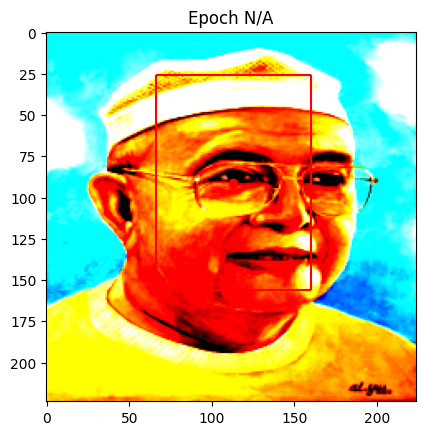

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7227589..2.6400006].


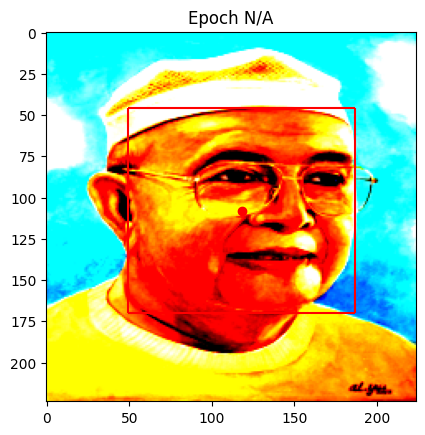

0.4549424648284912

In [ ]:
img_num = 56

model_cpu = model.cpu()
logits = (model_cpu(X_batch[img_num].cpu().unsqueeze(dim=0))).squeeze()
visualize_prediction(X_batch[img_num].cpu(), logits.cpu(), 'N/A')
visualize_prediction(X_batch[img_num].cpu(), y_batch[img_num].cpu(), 'N/A')

criterion(logits,y_batch[img_num].cpu()).item()



In [ ]:
torch.save(model.state_dict(), "bestt01.pt")

In [ ]:
X_me00 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_side.pt')
X_me01 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_straighton.pt')
X_me02 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun_hand.pt')
X_me03 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun.pt')

me_full = torch.stack((X_me00,X_me01, X_me02, X_me03))

In [ ]:
me_full.shape

torch.Size([4, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.640001].


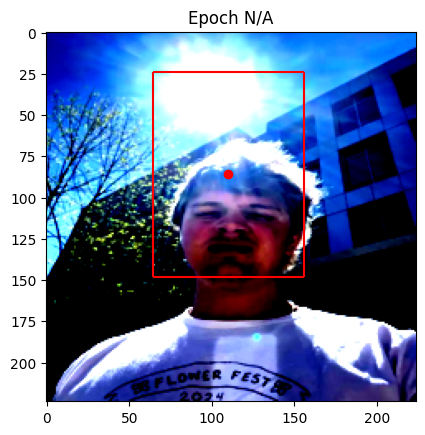

In [ ]:
model_cpu = model.cpu()
logits = (model_cpu(me_full[3].unsqueeze(dim=0))).squeeze()
visualize_prediction(me_full[3].cpu(), logits.cpu(), 'N/A')
